# Using Machine Learning to predict loan application decisions

### Loading Public Dataset from Lending Club, San Francisco

In [ ]:
import pandas as pd # Loading the datasets with only specific variables that are needed
accepted = pd.read_csv('LoanStats3a.csv',dtype = object)[['loan_amnt',
                                                          'dti','zip_code','addr_state','emp_length']]
rejected = pd.read_csv('RejectStatsA.csv',dtype = object)[['Amount Requested',
                                                           'Debt-To-Income Ratio',
                                                           'Zip Code','State','Employment Length']]

In [3]:
accepted.head()

,loan_amnt,dti,zip_code,addr_state,emp_length
0,5000,27.65,860xx,AZ,10+ years
1,2500,1,309xx,GA,< 1 year
2,2400,8.72,606xx,IL,10+ years
3,10000,20,917xx,CA,10+ years
4,3000,17.94,972xx,OR,1 year


In [4]:
rejected = rejected.sample(frac=len(accepted)/len(rejected)).reset_index(drop=True)
rejected.head() # Adjusting the indexes before we concatenate the data together

,Amount Requested,Debt-To-Income Ratio,Zip Code,State,Employment Length
0,1500,0%,333xx,FL,2 years
1,3000,26.22%,135xx,NY,< 1 year
2,5000,25.68%,945xx,CA,5 years
3,9000,45.02%,422xx,KY,< 1 year
4,30000,1.07%,331xx,FL,< 1 year


In [5]:
print(len(accepted), len(rejected)) # balanced dataset

42538 42538


### Data Cleaning and Consolidation

In [6]:
accepted_final = accepted.rename(columns={'loan_amnt': 'Amount Requested','dti':'Debt-To-Income Ratio','zip_code':'Zip Code','addr_state':'State','emp_length':'Employment Length'})

accepted_1 = [1 for i in range(len(accepted_final))]
accepted_final['Accepted'] = pd.Series(accepted_1, index=accepted_final.index)
accepted_final.head() # Pre processing the names so that concatenation is error-free


,Amount Requested,Debt-To-Income Ratio,Zip Code,State,Employment Length,Accepted
0,5000,27.65,860xx,AZ,10+ years,1
1,2500,1,309xx,GA,< 1 year,1
2,2400,8.72,606xx,IL,10+ years,1
3,10000,20,917xx,CA,10+ years,1
4,3000,17.94,972xx,OR,1 year,1


In [7]:
accepted_0 = [0 for i in range(len(rejected))]
rejected['Accepted'] = pd.Series(accepted_0, index=rejected.index)
rejected.index = range(len(accepted_final), len(accepted_final) + len(rejected))

In [8]:
frames = (accepted_final,rejected)
dataset = pd.concat(frames)
dataset.head() # Concatenated Dataset of accepted and rejected applicants

,Amount Requested,Debt-To-Income Ratio,Zip Code,State,Employment Length,Accepted
0,5000,27.65,860xx,AZ,10+ years,1
1,2500,1,309xx,GA,< 1 year,1
2,2400,8.72,606xx,IL,10+ years,1
3,10000,20,917xx,CA,10+ years,1
4,3000,17.94,972xx,OR,1 year,1


### Data Pre-Processing for ML purposes

In [9]:
# Data pre-processing for removing records that are empty or not in the right format

indexes = [] # We maintain a list of indexes that we'll be using to extract the clean dataset

# These algorithms also help us understand how the cleaning needs to be done without creating any errors. 

for i in range(0,len(dataset)):
    
    emp_length = dataset['Employment Length'][i]
    zip_code = str(dataset['Zip Code'][i])[0:3]
    
    if emp_length == 'n/a' or zip_code == 'nan' or type(emp_length) == int or type(emp_length) == float:
        continue
    
    elif emp_length[0] == '<':
        indexes.append(i)
    
    elif emp_length[0:2] == '10':
        indexes.append(i)
        
    else:
        indexes.append(i)

for i in range(len(dataset['State'])):
    element = dataset['State'][i]
    
    if type(element) == float:
        if i in indexes:
            indexes.remove(i)

from sklearn.preprocessing import LabelEncoder

encode2 = LabelEncoder()
states = encode2.fit_transform(list(dataset['State']))

In [10]:
encode2.classes_ # By encoding the states, we can also see there is a 'nan' that we don't need. We've recorded the indexes for that record

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'nan'], dtype='<U3')

In [11]:
dti = [] # Evaluating the DTI ratios and cleaning them
types = []

data = list(dataset['Debt-To-Income Ratio'])

for i in data[0:len(accepted_final)]:
    amount = float(i)
    dti.append(amount)

for i in data[len(accepted_final):]:
    amount = i[0:len(i)-1]
    final = float(amount)
    dti.append(final)

In [12]:
print(len(dataset) - len(indexes))

1581


In [13]:
final_dataset = [] # Structuring the final dataset. We run through the specific indexes, clean data and collect it in an array of the required shape
final_target = []
for i in indexes:
    unit = []
    unit.append(float(dataset['Amount Requested'][i]))
    #unit.append(dti[i])
    unit.append(float(str(dataset['Zip Code'][i])[0:3]))
    unit.append(states[i])
    
    emp_length = dataset['Employment Length'][i]
    
    if emp_length[0] == '<':
        unit.append(0)
    
    elif emp_length[0:2] == '10':
        unit.append(10)
        
    else:
        unit.append(int(emp_length[0]))
    
    final_dataset.append(unit)
    final_target.append(dataset['Accepted'][i])

### Data Structuring for Train-test split in ML Algorithms

In [14]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into a training and test dataset with 90% dataset for testing

X_train, X_test, y_train, y_test = train_test_split(final_dataset,final_target,test_size=0.9, stratify=final_target)


### The Pipeline of models: A Standard Scaler and a KNN Classifier

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Running the model in the pipeline along with a Standard Scaler

model2 = KNeighborsClassifier(n_neighbors=100, weights= 'distance', algorithm= 'auto', p=2, metric= 'minkowski')

steps = [('scaler', StandardScaler()), ('KNN', model2)]
pipeline = Pipeline(steps)
y_train = np.array(y_train).reshape(len(y_train,))
pipeline.fit(X_train, y_train)
print('Score', pipeline.score(X_train, y_train))

Score 0.9847885974368188


### ML Metrics and Reports

In [17]:
# Initial classification report and confusion matrix on the training dataset
from sklearn.metrics import classification_report, confusion_matrix

prediction = pipeline.predict(X_train)
print(classification_report(y_train,prediction))
print(confusion_matrix(y_train,prediction)) 

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4207
           1       1.00      0.97      0.98      4142

   micro avg       0.98      0.98      0.98      8349
   macro avg       0.99      0.98      0.98      8349
weighted avg       0.99      0.98      0.98      8349

[[4204    3]
 [ 124 4018]]


In [18]:
# classification report and confusion matrix on the test dataset

prediction2 = pipeline.predict(X_test)

print('Score', pipeline.score(X_test, y_test))
print(classification_report(y_test,prediction2))
print(confusion_matrix(y_test,prediction2))

Score 0.7881723578101296
              precision    recall  f1-score   support

           0       0.79      0.80      0.79     37865
           1       0.79      0.78      0.78     37281

   micro avg       0.79      0.79      0.79     75146
   macro avg       0.79      0.79      0.79     75146
weighted avg       0.79      0.79      0.79     75146

[[30211  7654]
 [ 8264 29017]]


### Cross Validation and Prediction

In [19]:
# Cross Validation and Scores for each test

from sklearn.model_selection import cross_val_score, cross_val_predict

scores = cross_val_score(pipeline, final_dataset, final_target, cv=10)

print('Cross-validated scores:', scores)

Cross-validated scores: [0.80936415 0.80541253 0.80634731 0.80428794 0.80273087 0.78548329
 0.7987783  0.78775901 0.77482333 0.75805486]


In [20]:
print('Cross-validated scores:')
for i in scores:
    print(round(i,2))

Cross-validated scores:
0.81
0.81
0.81
0.8
0.8
0.79
0.8
0.79
0.77
0.76


In [21]:
# Cross Validation report - Very similar to our original test reports

predictions = cross_val_predict(pipeline, final_dataset, final_target, cv=20)
print(classification_report(final_target,predictions))
print(confusion_matrix(final_target,predictions))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80     42072
           1       0.79      0.79      0.79     41423

   micro avg       0.79      0.79      0.79     83495
   macro avg       0.79      0.79      0.79     83495
weighted avg       0.79      0.79      0.79     83495

[[33417  8655]
 [ 8535 32888]]


### Comparing Accuracy over different values of the number of neighbors

In [648]:
# Calculating the false negatives and false positives with the number of neighbors

from sklearn.metrics import precision_score, accuracy_score, recall_score

false_negatives = []
false_positives = []

for i in range(1,250):
    model = KNeighborsClassifier(n_neighbors=i, weights= 'distance', algorithm= 'auto', p=2, metric= 'minkowski')
    steps = [('scaler', StandardScaler()), ('KNN', model)]
    clf = Pipeline(steps)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    matrix = confusion_matrix(y_test,pred)
    false_positive = matrix[0][1]
    false_negative = matrix[1][0]
    false_positives.append(false_positive)
    false_negatives.append(false_negative)

245

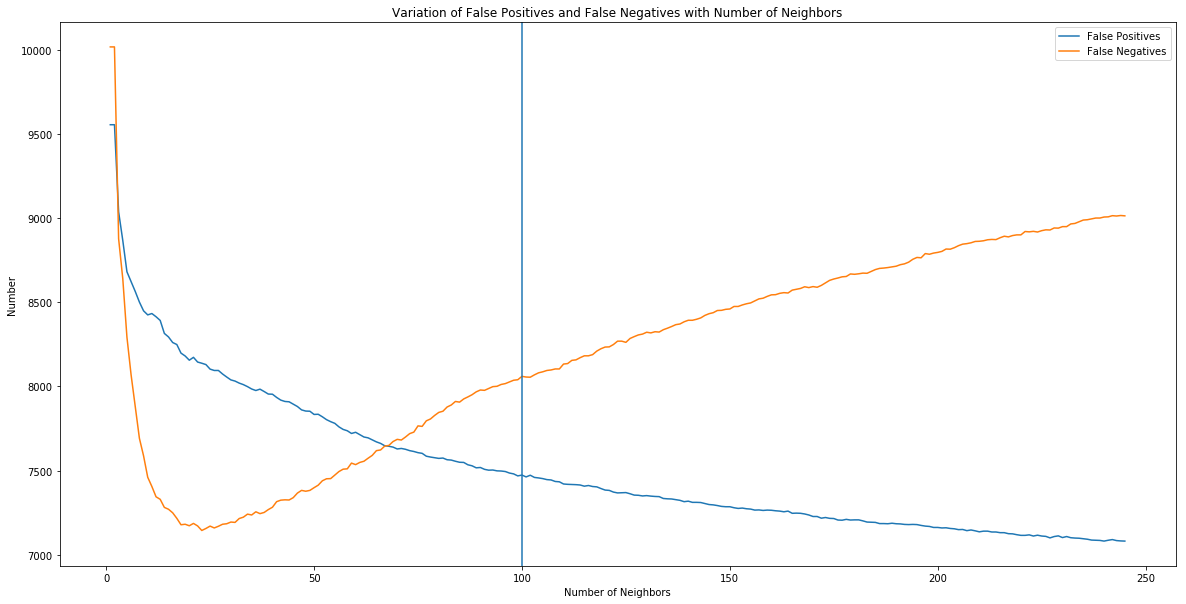

In [675]:
# Visualising the false negatives and false positives with the number of neighbors

plt.figure(figsize=(20,10))
plt.plot(range(1,246), false_positives,label='False Positives')
plt.plot(range(1,246), false_negatives, label='False Negatives')
plt.axvline(100)
plt.title('Variation of False Positives and False Negatives with Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Number')
plt.legend()
plt.show()

## A user-friendly function that takes the model and makes the prediction for a given input

In [22]:
# The Loan consultant
# The application function collects the data with python inputs

def application():
    amount = input('What Loan Amount are you requesting ?   ')
    print('\n')
    debt = input('What are your monthly debt obligations ?   ')
    print('\n')
    income = input('What is your monthly income?   ')
    print('\n')
    zip_code = input('Enter your ZIP Code   ')
    print('\n')
    state = encode2.transform([input('Enter your State   ')])
    print('\n')
    emp_length = input('How long have you been employed ? Please answer between 0 and 10   ')
    print('\n')

    test = [[float(amount), float(debt)/float(income)*100, float(zip_code[0:3]),state,float(emp_length)]]
    return test

# The model calculates the probability based on the outcomes of the model that we've built
#It analyses it, classifes it and then gives an appropriate outcome / graphical analysis of the applicant's situation

def loan_analysis(test):
    
    prob = pipeline.predict_proba(test)[0][1]
    print('For the loan request of $', str(test[0][0]), ', there is a ', str(round(prob*100,2)), 
          '% that it will be approved.')
    if prob >= 0.90:
        print('Your chances of loan approval are higher than 90% ! Good Luck', '\n')
    elif prob < 0.9 and prob > 0.5:
        print('You have fair chances of approval. You may consider changing the amount as per your \
              discretion','\n')
        
    if prob <= 0.5:
        print('With your current chances, we recommend you to adjust your loan amount as per the \
              statistics below: ','\n')
        amount = int(test[0][0])
        probabilities = []

        for amnt in range(100, 2*amount):
            probability = pipeline.predict_proba([[amnt,test[0][1], test[0][2],test[0][3],test[0][4]]])[0][1]
            probabilities.append(probability)
            
        index = probabilities.index(max(probabilities))
        threshold = range(100,2*amount)[index]
        
        print('The amount at which you have highest odds of approval is $', str(threshold),'\n')
        
        if max(probabilities) < 0.5:
            print('After the analysis, it has been determined that you may not be approved for a \
                  loan. Please read the guidelines for how to circumvent a rejection')
        
        
        plt.figure(figsize=(20,10))
        plt.plot(range(100,2*amount),probabilities)
        plt.axvline(threshold,color='red',label='Loan Amount with highest approval odds')
        plt.title('Variation of Loan Approval Odds with Loan Amount')
        plt.xlabel('Loan Amount')
        plt.ylabel('Odds of Approval')
        plt.show()       

In [ ]:
# Example of the application

test = application()
loan_analysis(test)

In [ ]:
# A random test of the Loan Analysis for a weak application in San Francisco

loan_analysis([[1000,0.16,'94103',encode2.transform(['CA']),7]])